# Data Setup

## Imports

In [83]:
# Data Access & Management
import kagglehub
import pandas as pd
import numpy as np

# Project Structure
from pathlib import Path
import shutil
from src.__00__paths import raw_data_dir, processed_data_dir

# Machine Learning Tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt


## Dataset Download

In [84]:
# List of files to check
raw_dataset = raw_data_dir / "patient_dataset.csv"

# Check and download
if raw_dataset.exists():
    print("✔️ Dataset is already downloaded.")
else:
    # Download dataset
    dataset_path = Path(kagglehub.dataset_download("arjunnsharma/patient-dataset-for-clustering-raw-data"))

    if not dataset_path.exists():
        raise FileNotFoundError("⚠ Dataset not found.")

    # Check for an extra "Data" folder
    data_root = dataset_path / "Data" if (dataset_path / "Data").exists() else dataset_path

    # Copy files/folders to raw_data_dir
    for item in data_root.iterdir():
        target = raw_data_dir / item.name
        if item.is_file():
            shutil.copy2(item, target)

    print("✔️ Dataset successfully downloaded.")

✔️ Dataset is already downloaded.


## Load Datasets

In [85]:
raw_df = pd.read_csv(raw_dataset)

## Dataset Augmentation

In [86]:
print("Shape:", raw_df.shape)

# NaN counts per column
nan_cnt = raw_df.isna().sum()

# 'Unknown' count aligned to columns (zeros except smoking_status)
unknown_cnt = pd.Series(0, index=raw_df.columns)
if 'smoking_status' in raw_df.columns:
    unknown_cnt['smoking_status'] = (
        raw_df['smoking_status'].astype(str).str.strip().str.lower().eq('unknown').sum()
    )

# Combine into one table
gaps = pd.DataFrame({
    "NaN": nan_cnt,
    "'Unknown' (smoking_status)": unknown_cnt
})
gaps["Total gaps"] = gaps["NaN"] + gaps["'Unknown' (smoking_status)"]
gaps["% of rows (total)"] = (gaps["Total gaps"] / len(raw_df) * 100).round(2)

# Sort by most problematic
gaps = gaps.sort_values("Total gaps", ascending=False)
gaps.drop(columns=["NaN", "'Unknown' (smoking_status)"], inplace=True)
display(gaps)


Shape: (6000, 16)


,Total gaps,% of rows (total)
skin_thickness,614,10.23
plasma_glucose,609,10.15
insulin,568,9.47
smoking_status,476,7.93
gender,472,7.87
residence_type,455,7.58
age,0,0.00
chest_pain_type,0,0.00
blood_pressure,0,0.00
cholesterol,0,0.00


In [87]:
# Start from raw
df = raw_df.copy()
df.head()

,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,residence_type,smoking_status
0,24,1.0,4,250,139,212,0,108.0,33.0,109.0,37.999303,0.480277,1,1,Urban,Smoker
1,29,0.0,4,132,187,147,0,202.0,42.0,NaN,25.588346,0.283986,1,1,Urban,Unknown
2,46,0.0,3,271,185,193,0,149.0,43.0,102.0,37.892029,2.472309,1,0,Rural,Non-Smoker
3,73,NaN,2,102,200,125,0,105.0,77.0,165.0,18.660241,1.472052,0,1,Rural,Smoker
4,49,1.0,3,91,163,192,0,162.0,31.0,170.0,12.767980,0.537627,1,1,Rural,Smoker


### Feature Imputation

#### Smoking Status Feature

In [88]:
# Smoking Status
df['smoker'] = df['smoking_status'].map({"Smoker": 1, "Non-Smoker": -1, "Unknown": 0})
df.drop(columns=['smoking_status'], inplace=True)

#### Gender Feature & Resistance Rural

* Fill with the Most Frequent Ratio for Both as it's almost ~7-8% Gap

In [89]:
most_freq_gender = df['gender'].mode(dropna=True)[0]
df['gender'] = df['gender'].fillna(most_freq_gender)
df['gender'] = df['gender'].astype(int)

most_freq_residence = df['residence_type'].mode(dropna=True)[0]
df['residence_type'] = df['residence_type'].fillna(most_freq_residence)
df['residence_type'] = df['residence_type'].map({'Urban': 0, 'Rural': 1})

#### Regression Features [Skin Thickness - Plasma Glucose - Insulin]
* We use median fill as it's robust, ignores how far the extreme values are and just finds the middle rank

In [90]:
regression_features = ['skin_thickness', 'plasma_glucose', 'insulin']
for column in regression_features:
    median = df[column].median()
    df[column] = df[column].fillna(median)

In [91]:
print("Shape:", df.shape)

Shape: (6000, 16)


## Save Clean Data

In [92]:
clean_path = processed_data_dir / "clean_preScaled_data.csv"
df.to_csv(clean_path, index=False)
print(f"✔️ Clean (pre-scaled) saved → {'/'.join(clean_path.parts[-3:])}")

✔️ Clean (pre-scaled) saved → data/processed/clean_preScaled_data.csv


## Feature Normalizing

In [93]:
scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Check results
print(df.describe().T[['mean', 'std']])

                           mean       std
age               -1.379637e-16  1.000083
gender            -6.158037e-17  1.000083
chest_pain_type    3.434290e-17  1.000083
blood_pressure     1.634248e-16  1.000083
cholesterol        2.303343e-16  1.000083
max_heart_rate    -2.202682e-16  1.000083
exercise_angina    3.286260e-17  1.000083
plasma_glucose    -6.158037e-17  1.000083
skin_thickness    -1.302662e-17  1.000083
insulin            2.318146e-16  1.000083
bmi                1.018445e-16  1.000083
diabetes_pedigree -7.194245e-17  1.000083
hypertension      -2.486900e-17  1.000083
heart_disease      6.454097e-17  1.000083
residence_type    -6.276461e-17  1.000083
smoker             1.184238e-18  1.000083


## Feature Weighting

In [94]:
# Define feature weights
weights = {
    # High importance
    'plasma_glucose': 1.8,
    'blood_pressure': 1.8,
    'cholesterol': 1.8,
    'bmi': 1.8,
    'hypertension': 1.8,
    'heart_disease': 1.8,

    # Medium importance
    'chest_pain_type': 1.3,
    'exercise_angina': 1.3,
    'max_heart_rate': 1.3,
    'insulin': 1.3,
}
for col, val in weights.items():
    df[col] *= val

## Dimensionality Reduction

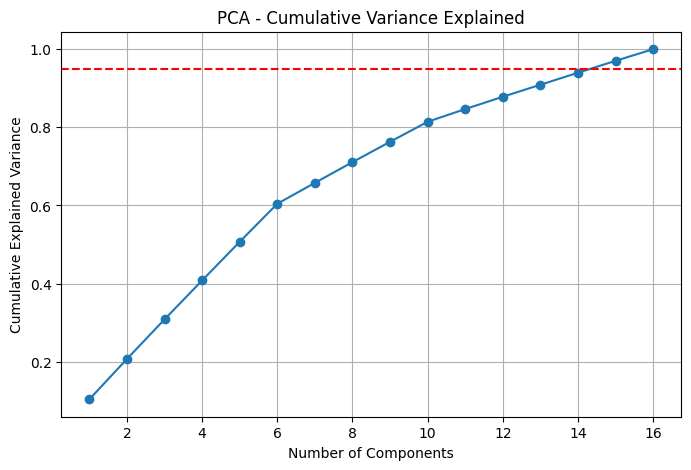

Number of components to keep 95% variance: 15


In [95]:
pca = PCA()
pca.fit(df)

# Calculate explained variance ratio
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Variance Explained')
plt.grid(True)
plt.show()

# Choose number of components to keep 95% variance
n_components = np.argmax(explained_var >= 0.95) + 1
print(f"Number of components to keep 95% variance: {n_components}")

# Transform dataset to reduced dimensions
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df)

> PCA show that 95% of the variance is explained by 15/16 components.
> which is high so we can keep all the components.


## Save Processed Data

In [96]:
processed_data_path = processed_data_dir / "processed_patients_dataset.csv"
df.to_csv(processed_data_path, index=False)
print(f"✔️ Processed data saved → {'/'.join(processed_data_path.parts[-3:])}")
df.head()

✔️ Processed data saved → data/processed/processed_patients_dataset.csv


,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,residence_type,smoker
0,-1.411160,1.086750,1.713514,4.312744,-2.413512,1.998757,-1.30826,-1.927143,-1.223635,-0.961099,1.247612,-1.180427,1.795206,1.806612,-0.925128,1.033893
1,-1.173253,-0.920175,1.713514,-0.084865,-0.778264,0.059780,-1.30826,1.477383,-0.815278,-0.025465,-0.674010,-1.464958,1.795206,1.806612,-0.925128,-0.008338
2,-0.364370,-0.920175,0.556906,5.095369,-0.846400,1.431979,-1.30826,-0.442190,-0.769905,-1.288572,1.231002,1.707102,1.795206,-1.793412,1.080932,-1.050569
3,0.920327,-0.920175,-0.599701,-1.202901,-0.335385,-0.596489,-1.30826,-2.035798,0.772778,1.658677,-1.746706,0.257191,-1.804806,1.806612,1.080932,1.033893
4,-0.221626,1.086750,0.556906,-1.612848,-1.595888,1.402149,-1.30826,0.028649,-1.314381,1.892586,-2.659021,-1.097297,1.795206,1.806612,1.080932,1.033893
